This project, "**Analyzing and Predicting Election Outcomes in Indian Politics,**" employs data mining and machine learning techniques to unravel the complexities of electoral dynamics. It explores candidate attributes, party affiliations, and historical trends, enhancing predictive accuracy through algorithms - **Decision Trees, Random Forests, SVM, and XGBoost**. Noteworthy contributions include SVM optimization through grid search and a thorough comparative study of model performance. Visualizations shed light on the relationships between winning candidates and demographics. Acknowledging successes and limitations, the project navigates the challenges of model interpretability in political contexts, presenting a nuanced exploration of election prediction in Indian politics.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving LS_2.0.csv to LS_2.0.csv


In [ ]:
import numpy as np
import pandas as pd
!pip install shap
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
import shap
import os, sys
from collections import defaultdict
from urllib.request import urlopen
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets
import geopandas as gpd
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
from wordcloud import WordCloud , ImageColorGenerator
from PIL import Image
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
vote=pd.read_csv('LS_2.0.csv')
vote.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL\nCASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690


In [ ]:
vote.isnull().sum()

STATE                                          0
CONSTITUENCY                                   0
NAME                                           0
WINNER                                         0
PARTY                                          0
SYMBOL                                       245
GENDER                                       245
CRIMINAL\nCASES                              245
AGE                                          245
CATEGORY                                     245
EDUCATION                                    245
ASSETS                                       245
LIABILITIES                                  245
GENERAL\nVOTES                                 0
POSTAL\nVOTES                                  0
TOTAL\nVOTES                                   0
OVER TOTAL ELECTORS \nIN CONSTITUENCY          0
OVER TOTAL VOTES POLLED \nIN CONSTITUENCY      0
TOTAL ELECTORS                                 0
dtype: int64

In [ ]:
vote[vote.SYMBOL.isnull()==True]['NAME'].unique()

array(['NOTA'], dtype=object)

**Data Cleaning and Preprocessing**

In [ ]:
#DATA CLEANING
def value_cleaner(x):
    try:
        str_temp = (x.split('Rs')[1].split('\n')[0].strip())
        str_temp_2 = ''
        for i in str_temp.split(","):
            str_temp_2 = str_temp_2+i
        return str_temp_2
    except:
        x = 0
        return x
vote['ASSETS'] = vote['ASSETS'].apply((value_cleaner))
vote['LIABILITIES'] = vote['LIABILITIES'].apply((value_cleaner))
vote.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL\nCASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


In [ ]:
vote.rename(columns={"CRIMINAL\nCASES": "CRIMINAL CASES", "GENERAL\nVOTES": "GENERAL VOTES", "POSTAL\nVOTES": "POSTAL VOTES","TOTAL\nVOTES": "TOTAL VOTES","OVER TOTAL ELECTORS \nIN CONSTITUENCY": "OVER TOTAL ELECTORS IN CONSTITUENCY","OVER TOTAL VOTES POLLED \nIN CONSTITUENCY": "OVER TOTAL VOTES POLLED IN CONSTITUENCY"}, inplace=True)
vote.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


In [ ]:
vote.EDUCATION.unique()

array(['12th Pass', 'Post Graduate', nan, 'Doctorate', 'Graduate',
       'Others', '10th Pass', '8th Pass', 'Graduate Professional',
       'Literate', 'Illiterate', '5th Pass', 'Not Available',
       'Post Graduate\n'], dtype=object)

In [ ]:
vote.EDUCATION.replace({'Post Graduate\n':'Post Graduate'},inplace=True)
vote.EDUCATION.unique()

array(['12th Pass', 'Post Graduate', nan, 'Doctorate', 'Graduate',
       'Others', '10th Pass', '8th Pass', 'Graduate Professional',
       'Literate', 'Illiterate', '5th Pass', 'Not Available'],
      dtype=object)

In [ ]:
vote.dtypes

STATE                                       object
CONSTITUENCY                                object
NAME                                        object
WINNER                                       int64
PARTY                                       object
SYMBOL                                      object
GENDER                                      object
CRIMINAL CASES                              object
AGE                                        float64
CATEGORY                                    object
EDUCATION                                   object
ASSETS                                      object
LIABILITIES                                 object
GENERAL VOTES                                int64
POSTAL VOTES                                 int64
TOTAL VOTES                                  int64
OVER TOTAL ELECTORS IN CONSTITUENCY        float64
OVER TOTAL VOTES POLLED IN CONSTITUENCY    float64
TOTAL ELECTORS                               int64
dtype: object

In [ ]:
vote[vote['CRIMINAL CASES']=='Not Available'].head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
468,Bihar,BUXAR,Ramchandra Singh Yadav,0,IND,Almirah,MALE,Not Available,42.0,GENERAL,Not Available,0,0,10721,9,10730,0.586540,1.087175,1829373
532,Tamil Nadu,CHIDAMBARAM,SIVAJOTHI M,0,NTK,Ganna Kisan,MALE,Not Available,35.0,SC,Not Available,0,0,37329,142,37471,2.531445,3.246331,1480222
612,Uttar Pradesh,DEORIA,BINOD KUMAR JAISWAL,0,BSP,Elephant,MALE,Not Available,56.0,GENERAL,Not Available,0,0,327728,2985,330713,18.852693,32.563441,1754195
613,Uttar Pradesh,DEORIA,NIYAZ AHMED,0,INC,Hand,MALE,Not Available,57.0,GENERAL,Not Available,0,0,50749,307,51056,2.910509,5.027196,1754195
654,Tamil Nadu,DINDIGUL,"JOTHIMUTHU, K.",0,PMK,Mango,MALE,Not Available,48.0,GENERAL,Not Available,0,0,206782,769,207551,13.460896,17.877979,1541881


In [ ]:
vote['ASSETS']=pd.to_numeric(vote['ASSETS'])
vote['LIABILITIES']=pd.to_numeric(vote['LIABILITIES'])
vote['CRIMINAL CASES'].replace({np.NaN:0})
vote['CRIMINAL CASES'] = pd.to_numeric(vote['CRIMINAL CASES'], errors='coerce').fillna(0).astype(np.int64)

In [ ]:
vote.dtypes

STATE                                       object
CONSTITUENCY                                object
NAME                                        object
WINNER                                       int64
PARTY                                       object
SYMBOL                                      object
GENDER                                      object
CRIMINAL CASES                               int64
AGE                                        float64
CATEGORY                                    object
EDUCATION                                   object
ASSETS                                       int64
LIABILITIES                                  int64
GENERAL VOTES                                int64
POSTAL VOTES                                 int64
TOTAL VOTES                                  int64
OVER TOTAL ELECTORS IN CONSTITUENCY        float64
OVER TOTAL VOTES POLLED IN CONSTITUENCY    float64
TOTAL ELECTORS                               int64
dtype: object

In [ ]:
vote2 = vote.copy()
vote.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,0,NaN,NaN,NaN,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


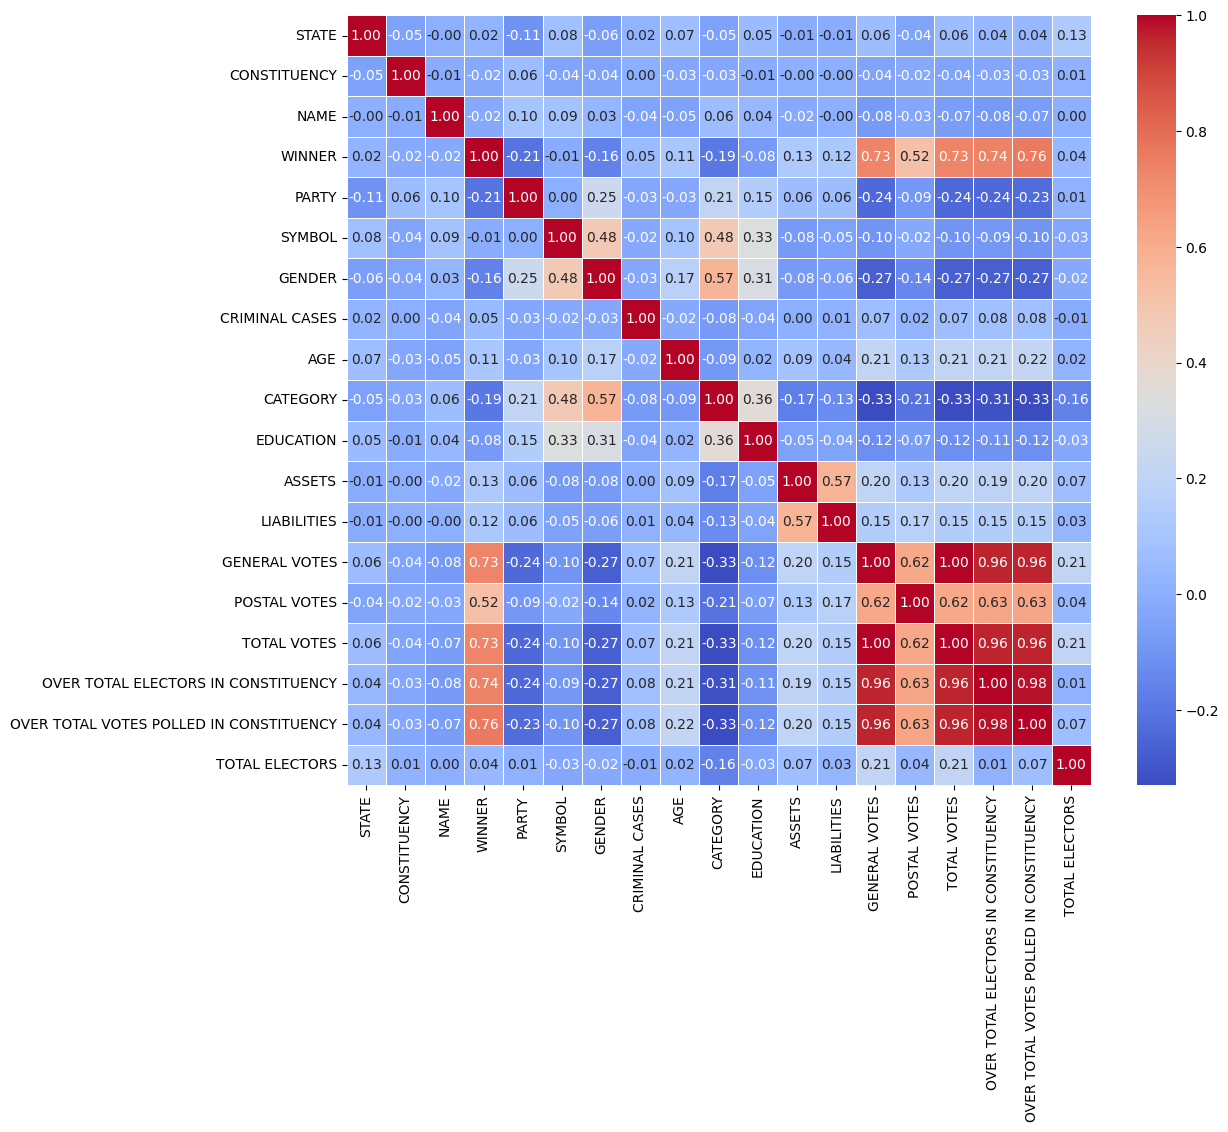

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,0,NaN,NaN,NaN,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


In [ ]:
from sklearn.preprocessing import LabelEncoder

numerical_columns = vote2.select_dtypes(include=['int', 'float']).columns
categorical_columns = vote2.select_dtypes(include=['object']).columns

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
for col in categorical_columns:
    vote2[col] = label_encoder.fit_transform(vote2[col])


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = vote2.corr().round(2)

# Set the size of the figure
plt.figure(figsize=(12, 10))

# Create the heatmap with annotations
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

#heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
#heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

# Show the heatmap
plt.show()
vote.head()


In [ ]:
#RELATION BETWEEN PARTY AND WINS
part_win = vote.groupby('PARTY').apply(lambda x: x['WINNER'].sum()).reset_index(name='# Wins')
part_win.sort_values(by='# Wins', ascending=False, inplace=True)
top_part_win = part_win.head(15)

print(top_part_win)


      PARTY  # Wins
26      BJP     300
46      INC      52
42      DMK      23
13     AITC      22
131   YSRCP      22
109     SHS      18
54    JD(U)      16
35      BSP      11
24      BJD      11
120     TRS       9
70      LJP       6
38   CPI(M)       5
78      NCP       5
112      SP       5
47      IND       4


**Exploratory Data Analysis (EDA)**

In [ ]:

part_win = vote.groupby('PARTY').apply(lambda x: x['WINNER'].sum()).reset_index(name='# Wins')
part_win.sort_values(by='# Wins', ascending=False, inplace=True)
top_part_win = part_win.head(15)


fig = px.bar(top_part_win, x='PARTY', y='# Wins', color='# Wins', title='Win Counts by a Political Party in 2019')
fig.update_layout(title_text='Win Counts by a Political Party in 2019', template='plotly_dark')


pio.show(fig, renderer='colab')


In [ ]:
'''prty_cnt_win=pd.merge(prty_cnt,part_win,how='inner',left_on='PARTY',right_on='PARTY')
prty_cnt_win['Lost']=prty_cnt_win['# Constituency']-prty_cnt_win['# Wins']
prty_wins_cnt=prty_cnt_win[['PARTY','# Wins']]
prty_wins_cnt['Verdict']='Constituency Won'
prty_loss_cnt=prty_cnt_win[['PARTY','Lost']]
prty_loss_cnt['Verdict']='Constituency Lost'
prty_wins_cnt.columns=['Party','Counts','Verdict']
prty_loss_cnt.columns=['Party','Counts','Verdict']
top_prty_wins_cnt=prty_wins_cnt[:15]
prty_loss_cnt_cnt=prty_loss_cnt[:15]
prt_win_loss=pd.concat([top_prty_wins_cnt,prty_loss_cnt_cnt])
fig = px.bar(prt_win_loss, x='Party', y='Counts', color='Verdict')
fig.update_layout(title_text='Win vs Loss Analysis for the Top Parties',template='plotly_dark')
fig.show()'''

In [ ]:
#REALTION WITH GENDERS
vote_gndr = vote[vote['PARTY'] != 'NOTA']
gndr_overall = vote_gndr.groupby('GENDER').apply(lambda x: x['NAME'].count()).reset_index(name='Counts')
gndr_overall['Category'] = 'Overall Gender Ratio'
winners = vote_gndr[vote_gndr['WINNER'] == 1]
gndr_winner = winners.groupby('GENDER').apply(lambda x: x['NAME'].count()).reset_index(name='Counts')
gndr_winner['Category'] = 'Winning Gender Ratio'
gndr_overl_win = pd.concat([gndr_winner, gndr_overall])


fig = px.bar(gndr_overl_win, x='GENDER', y='Counts', color='Category', barmode='group')
fig.update_layout(title_text='Participation vs Win Counts analysis for the Genders', template='plotly_dark')

pio.show(fig, renderer='colab')


In [ ]:
#REALTION BETWEEN EDUCATION
ed_valid = vote[vote['PARTY'] != "NOTA"]

ed_cnt = ed_valid.groupby('EDUCATION').apply(lambda x: x['PARTY'].count()).reset_index(name='Counts')
fig = px.pie(ed_cnt, values='Counts', names='EDUCATION', title='Overall Education Qualification of all the Nominees', template='plotly_dark')

pio.show(fig, renderer='colab')

ed_won = ed_valid[ed_valid['WINNER'] == 1]
ed_win_cnt = ed_won.groupby('EDUCATION').apply(lambda x: x['PARTY'].count()).reset_index(name='Counts')
fig2 = px.pie(ed_win_cnt, values='Counts', names='EDUCATION', title='Education Qualification of the Winners', template='plotly_dark')

pio.show(fig2, renderer='colab')


In [ ]:
#RELATION WITH AGE
age_cnt = ed_valid.groupby(['AGE', 'GENDER']).apply(lambda x: x['NAME'].count()).reset_index(name='Counts')

fig = px.histogram(age_cnt, x="AGE", y='Counts', color='GENDER', marginal='violin', title='Age Counts Distribution among the politicians')
fig.update_layout(title_text='Age Counts Distribution among the politicians', template='plotly_dark')

pio.show(fig, renderer='colab')


In [ ]:
#REALTION WITH CATEGORY
vote_cat = vote[vote['PARTY'] != 'NOTA']
cat_overall = vote_cat.groupby('CATEGORY').apply(lambda x: x['NAME'].count()).reset_index(name='Counts')
cat_overall['Category'] = 'Overall Category Counts'

winners_cat = vote_cat[vote_cat['WINNER'] == 1]
cat_winner = winners_cat.groupby('CATEGORY').apply(lambda x: x['NAME'].count()).reset_index(name='Counts')
cat_winner['Category'] = 'Winning Category Ratio'

cat_overl_win = pd.concat([cat_winner, cat_overall])

fig = px.bar(cat_overl_win, x='CATEGORY', y='Counts', color='Category', barmode='group')
fig.update_layout(title_text='Participation vs Win Counts for the Category in Politics', template='plotly_dark')

pio.show(fig, renderer='colab')


In [ ]:
s_liab_name = ed_valid[['NAME', 'PARTY', 'ASSETS', 'LIABILITIES', 'STATE', 'CONSTITUENCY', 'WINNER']]
s_liab_name['WINNER'].replace({1: 'Yes', 0: 'No'}, inplace=True)
win_as_liab_name = s_liab_name[s_liab_name['WINNER'] == 'Yes']
win_as_liab_name.sort_values(by='ASSETS', ascending=False, inplace=True)

fig = px.scatter(win_as_liab_name, x='ASSETS', y='LIABILITIES', color='STATE', size='ASSETS',
                 hover_data=['NAME', 'PARTY', 'CONSTITUENCY', 'STATE', 'WINNER'],
                 title='Assets vs Liabilities for the Winning Politicians')
fig.update_layout(title_text='Assets vs Liabilities for the Winning Politicians', template='plotly_dark')

pio.show(fig, renderer='colab')


PREDICTION

In [ ]:
vote.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,0,NaN,NaN,NaN,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


IMPLEMENTING FOLLOWING ALGORITHMS:


*   Decision Tree
*   Random Forest

*   SVM
*   XG Boost



In [ ]:
#Model Preprocessing
vote_df=vote[vote['PARTY']!='NOTA']
vote_df['GENDER'].replace({'MALE':1,'FEMALE':2},inplace=True)
vote_df['CATEGORY'].replace({'GENERAL':1,'SC':2,'ST':3},inplace=True)
i=1
parties_dict={}
for j in vote_df['PARTY']:
    if j in parties_dict:
        continue
    else:
        parties_dict[j]=i
        i+=1
vote_df['PARTY'].replace(parties_dict,inplace=True)
a=1
edu_dict={}
for b in vote_df['EDUCATION']:
    if b in edu_dict:
        continue
    else:
        edu_dict[b]=a
        a+=1
vote_df['EDUCATION'].replace(edu_dict,inplace=True)
df1 = vote_df[['STATE','CONSTITUENCY','WINNER','PARTY','SYMBOL','GENDER','CRIMINAL CASES','AGE','CATEGORY','EDUCATION','TOTAL VOTES','TOTAL ELECTORS','ASSETS','LIABILITIES']]
#df1 = vote_df[['STATE','CONSTITUENCY','WINNER','PARTY','GENDER','CRIMINAL CASES','AGE','CATEGORY','EDUCATION','TOTAL VOTES','TOTAL ELECTORS','ASSETS','LIABILITIES']]
num_cols = ['PARTY','EDUCATION','CRIMINAL CASES','AGE','TOTAL VOTES','TOTAL ELECTORS','ASSETS','CATEGORY','LIABILITIES','GENDER']
print(df1)
dataset = pd.get_dummies(df1)
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
scaling_columns = num_cols
dataset[scaling_columns] = standardScaler.fit_transform(dataset[scaling_columns])
dataset.head()

              STATE     CONSTITUENCY  WINNER  PARTY    SYMBOL  GENDER  \
0         Telangana         ADILABAD       1      1     Lotus       1   
1         Telangana         ADILABAD       0      2       Car       1   
2         Telangana         ADILABAD       0      3      Hand       1   
4     Uttar Pradesh             AGRA       1      1     Lotus       1   
5     Uttar Pradesh             AGRA       0      4  Elephant       1   
...             ...              ...     ...    ...       ...     ...   
2257    Maharashtra  YAVATMAL-WASHIM       0    132   Whistle       2   
2258    Maharashtra  YAVATMAL-WASHIM       0     18      SHIP       1   
2259      Telangana        ZAHIRABAD       1      2       Car       1   
2260      Telangana        ZAHIRABAD       0      3      Hand       1   
2261      Telangana        ZAHIRABAD       0      1     Lotus       1   

      CRIMINAL CASES   AGE  CATEGORY  EDUCATION  TOTAL VOTES  TOTAL ELECTORS  \
0                 52  52.0         3       

,WINNER,PARTY,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,TOTAL VOTES,TOTAL ELECTORS,ASSETS,...,SYMBOL_Tiller,SYMBOL_Tractor Chalata Kisan,SYMBOL_Triangle,SYMBOL_Truck,SYMBOL_Two Leaves,SYMBOL_Tyres,SYMBOL_Umbrella,SYMBOL_Walking Stick,SYMBOL_Water Melon,SYMBOL_Whistle
0,1,-0.628979,-0.382872,6.620242,-0.023051,2.251127,-1.242514,0.332957,-0.538876,-0.311731,...,0,0,0,0,0,0,0,0,0,0
1,0,-0.583879,-0.382872,-0.190426,0.145491,2.251127,-0.872637,0.103781,-0.538876,-0.274420,...,0,0,0,0,0,0,0,0,0,0
2,0,-0.538780,-0.382872,0.202498,-0.023051,2.251127,-1.242514,0.085873,-0.538876,-0.230717,...,0,0,0,0,0,0,0,0,0,0
4,1,-0.628979,-0.382872,0.464446,0.482577,0.816718,-0.502761,1.387657,0.876978,-0.139047,...,0,0,0,0,0,0,0,0,0,0
5,0,-0.493681,-0.382872,-0.190426,-0.444408,0.816718,-0.872637,0.559766,0.876978,0.005336,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#UPSAMPLING - Recognizing the presence of class imbalance, we applied upsampling techniques to address this issue.
from sklearn.utils import resample

df_not_winner = dataset[dataset.WINNER == 0]
df_winner = dataset[dataset.WINNER == 1]
df_winner_upsampled = resample(df_winner, replace=True, n_samples=1452, random_state=0)
df_total_upsampled = pd.concat([df_not_winner, df_winner_upsampled])
df_total_upsampled.WINNER.value_counts()
y = df_total_upsampled['WINNER']
X = df_total_upsampled.drop(['WINNER'], axis=1)
print(df_total_upsampled.value_counts())

WINNER  PARTY      GENDER     CRIMINAL CASES  AGE        CATEGORY   EDUCATION  TOTAL VOTES  TOTAL ELECTORS  ASSETS     LIABILITIES  STATE_Andaman & Nicobar Islands  STATE_Andhra Pradesh  STATE_Arunachal Pradesh  STATE_Assam  STATE_Bihar  STATE_Chandigarh  STATE_Chhattisgarh  STATE_Dadra & Nagar Haveli  STATE_Daman & Diu  STATE_Goa  STATE_Gujarat  STATE_Haryana  STATE_Himachal Pradesh  STATE_Jammu & Kashmir  STATE_Jharkhand  STATE_Karnataka  STATE_Kerala  STATE_Lakshadweep  STATE_Madhya Pradesh  STATE_Maharashtra  STATE_Manipur  STATE_Meghalaya  STATE_Mizoram  STATE_NCT OF Delhi  STATE_Nagaland  STATE_Odisha  STATE_Puducherry  STATE_Punjab  STATE_Rajasthan  STATE_Sikkim  STATE_Tamil Nadu  STATE_Telangana  STATE_Tripura  STATE_Uttar Pradesh  STATE_Uttarakhand  STATE_West Bengal  CONSTITUENCY_ADILABAD  CONSTITUENCY_AGRA  CONSTITUENCY_AHMADNAGAR  CONSTITUENCY_AHMEDABAD EAST  CONSTITUENCY_AHMEDABAD WEST  CONSTITUENCY_AJMER  CONSTITUENCY_AKBARPUR  CONSTITUENCY_AKOLA  CONSTITUENCY_ALAPPUZHA  

DECISION TREE

In [ ]:
#Decision Tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df_total_upsampled.drop('WINNER', axis=1)
y = df_total_upsampled['WINNER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)

from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, precision, recall, and F1 score
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix and other metrics
print("Confusion Matrix:")
print(conf_matrix)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.9216354344122658
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       300
           1       0.89      0.96      0.92       287

    accuracy                           0.92       587
   macro avg       0.92      0.92      0.92       587
weighted avg       0.92      0.92      0.92       587

Confusion Matrix:
[[265  35]
 [ 11 276]]
Sensitivity: 0.9616724738675958
Specificity: 0.8833333333333333
Precision: 0.887459807073955
Recall: 0.9616724738675958
F1 Score: 0.923076923076923


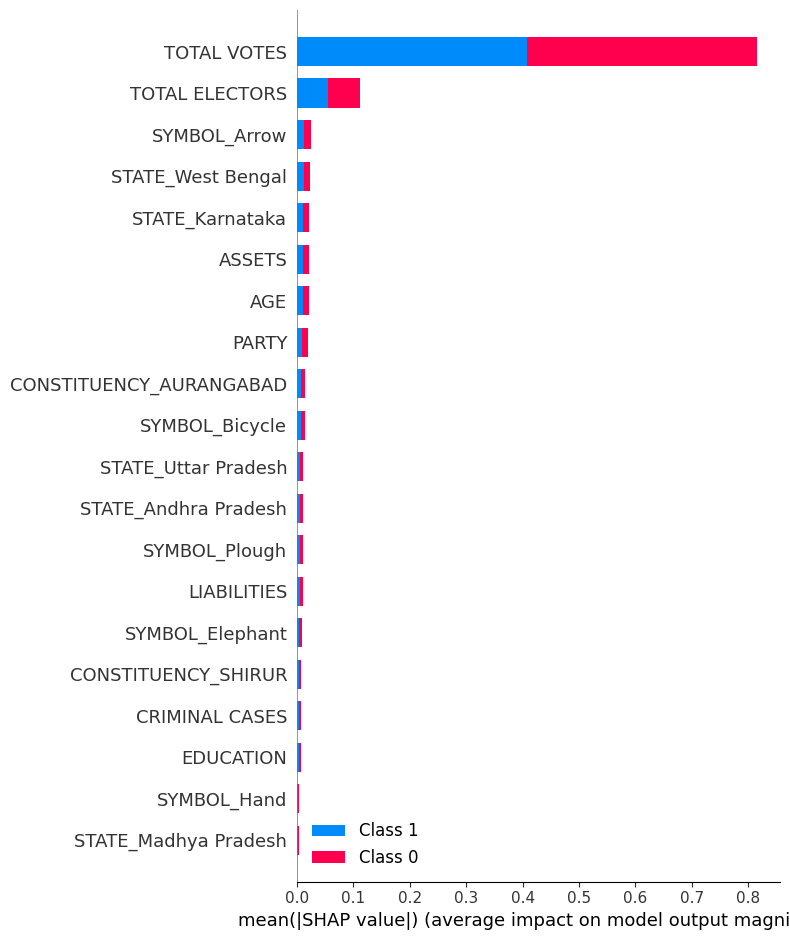

In [ ]:
explainer=shap.TreeExplainer(decision_tree)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :])


Shap analysis performed on decision tree model, concludes that total votes and total electors have the most impact on output predicted.

Best Hyperparameters: {'max_depth': 40, 'min_samples_split': 2}
Best Accuracy: 0.9233390119250426
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       300
           1       0.89      0.97      0.92       287

    accuracy                           0.92       587
   macro avg       0.93      0.92      0.92       587
weighted avg       0.93      0.92      0.92       587



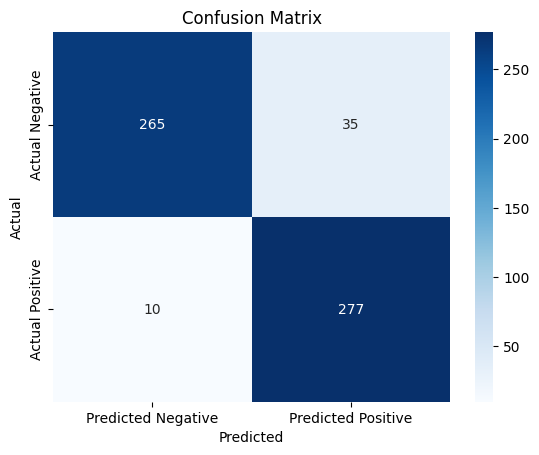

Sensitivity: 0.9651567944250871
Specificity: 0.8833333333333333
Precision: 0.8878205128205128
Recall: 0.9651567944250871
F1 Score: 0.9248747913188647


In [ ]:
#Decision Tree with grid search
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df_total_upsampled.drop('WINNER', axis=1)
y = df_total_upsampled['WINNER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define a grid of hyperparameters to search
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", accuracy)
print(report)
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, precision, recall, and F1 score
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

import seaborn as sns

# Assuming you already have the confusion matrix (conf_matrix) calculated
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


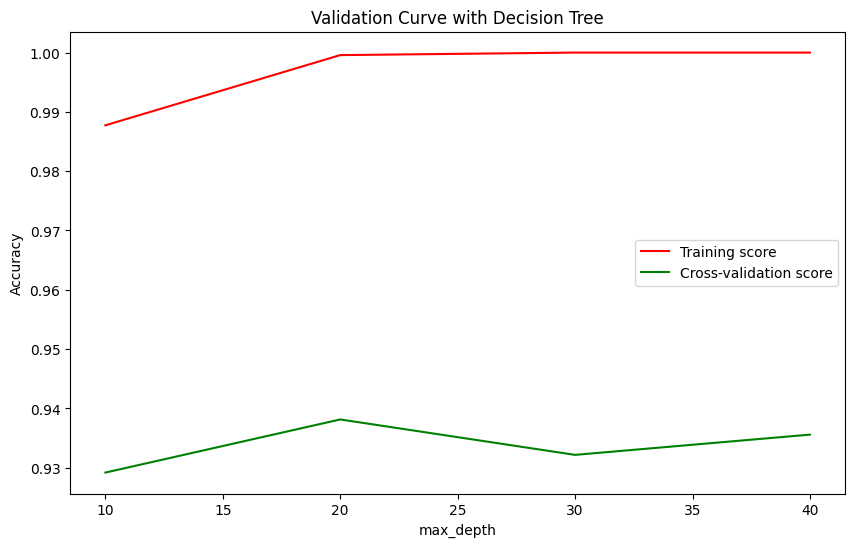

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

param_range = [10, 20, 30, 40]

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X_train, y_train,
    param_name="max_depth", param_range=param_range, cv=5, scoring="accuracy"
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Decision Tree")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.legend(loc="best")
plt.show()

Above is the validation curve, that shows the variation in accuracy with variation in max_depth.

RANDOM FOREST

In [ ]:
#random forest
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rf_scores = []
for k in range(1, 60):
    randomforest_classifier = RandomForestClassifier(n_estimators=k, random_state=0)
    score = cross_val_score(randomforest_classifier, X, y, cv=10)
    rf_scores.append(score.mean())

fig = px.scatter(x=[k for k in range(1, 60)], y=rf_scores, color=rf_scores, size=rf_scores)
fig.update_layout(title_text='Random Forest Cross-Validation Scores', template='plotly_dark')

pio.show(fig, renderer='colab')


The abve graph represents the 60 random forests that were produced vs the accuracy generated. The Random forest 38 and 52 with 38 and 52 decision trees generated respectively, produced maximum accuracy of 96.2131%.

In [ ]:
randomforest_classifier= RandomForestClassifier(n_estimators=38,random_state=0)
score=cross_val_score(randomforest_classifier,X,y,cv=10)
print('% Accuracy :', round(score.mean()*100,4))

% Accuracy : 96.2131


SUPPORT VECTOR MACHINE

Accuracy: 0.9216354344122658
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       300
           1       0.90      0.95      0.92       287

    accuracy                           0.92       587
   macro avg       0.92      0.92      0.92       587
weighted avg       0.92      0.92      0.92       587



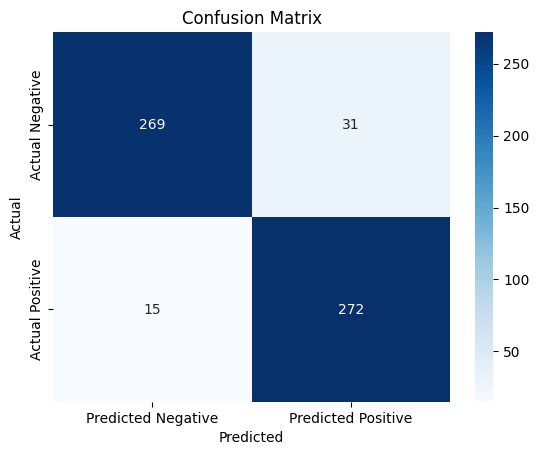

Sensitivity: 0.9477351916376306
Specificity: 0.8966666666666666
Precision: 0.8976897689768977
Recall: 0.9477351916376306
F1 Score: 0.9220338983050846


In [ ]:
#SVM
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report

X = df_total_upsampled.drop('WINNER', axis=1)
y = df_total_upsampled['WINNER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize the Support Vector Classifier (SVC)
svm = SVC(kernel='linear', C=1.0)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, precision, recall, and F1 score
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix and other metrics
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Best Accuracy: 0.9437819420783645
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       300
           1       0.92      0.97      0.94       287

    accuracy                           0.94       587
   macro avg       0.94      0.94      0.94       587
weighted avg       0.95      0.94      0.94       587



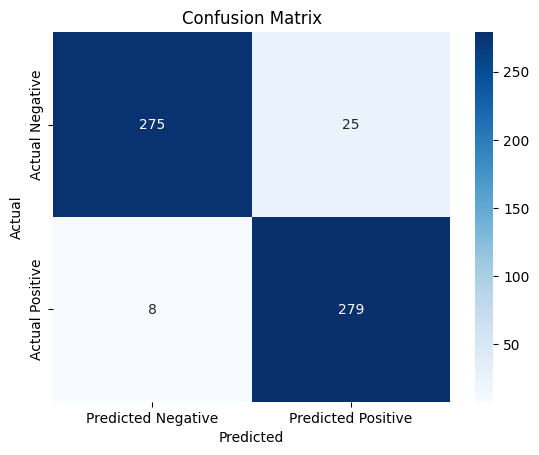

Sensitivity: 0.9721254355400697
Specificity: 0.9166666666666666
Precision: 0.9177631578947368
Recall: 0.9721254355400697
F1 Score: 0.9441624365482233


In [ ]:
#To improve the accuracy of SVM
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Adjust C as needed
    'kernel': ['linear', 'rbf', 'poly'],  # Try different kernels
    'gamma': [0.1, 1, 10]  # If using RBF or poly kernels
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Accuracy:", accuracy)
print(report)
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, precision, recall, and F1 score
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix and other metrics
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


XG BOOST

Accuracy: 0.9540034071550255
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       300
           1       0.92      0.99      0.95       287

    accuracy                           0.95       587
   macro avg       0.96      0.95      0.95       587
weighted avg       0.96      0.95      0.95       587



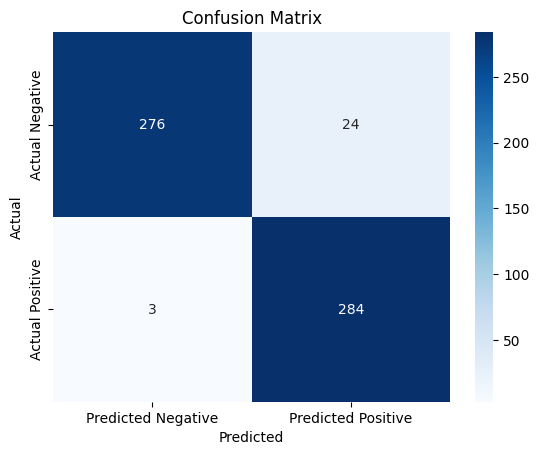

Sensitivity: 0.9895470383275261
Specificity: 0.92
Precision: 0.922077922077922
Recall: 0.9895470383275261
F1 Score: 0.9546218487394957


In [ ]:
#xgBoost
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df_total_upsampled.drop('WINNER', axis=1)
y = df_total_upsampled['WINNER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)
from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity, specificity, precision, recall, and F1 score
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the confusion matrix and other metrics
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


In [ ]:
# Get feature importances
feature_importance = xgb.feature_importances_

# Map feature names to their importance scores
feature_names = X_train.columns  # Replace with your feature names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
df1 = vote_df[['STATE','CONSTITUENCY','WINNER','PARTY','SYMBOL','GENDER','CRIMINAL CASES','AGE','CATEGORY','EDUCATION','TOTAL VOTES','TOTAL ELECTORS','ASSETS','LIABILITIES']]
# Print or visualize the sorted feature importance
for feature, importance in sorted_feature_importance:
    if(feature in df1):
        print(f"{feature}: {importance}")



TOTAL VOTES: 0.16016076505184174
TOTAL ELECTORS: 0.026118526235222816
CRIMINAL CASES: 0.01531502977013588
GENDER: 0.015268437564373016
PARTY: 0.01443542167544365
EDUCATION: 0.011035405099391937
ASSETS: 0.009694533422589302
LIABILITIES: 0.008694331161677837
AGE: 0.008428305387496948
CATEGORY: 0.004694500472396612


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[08:43:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



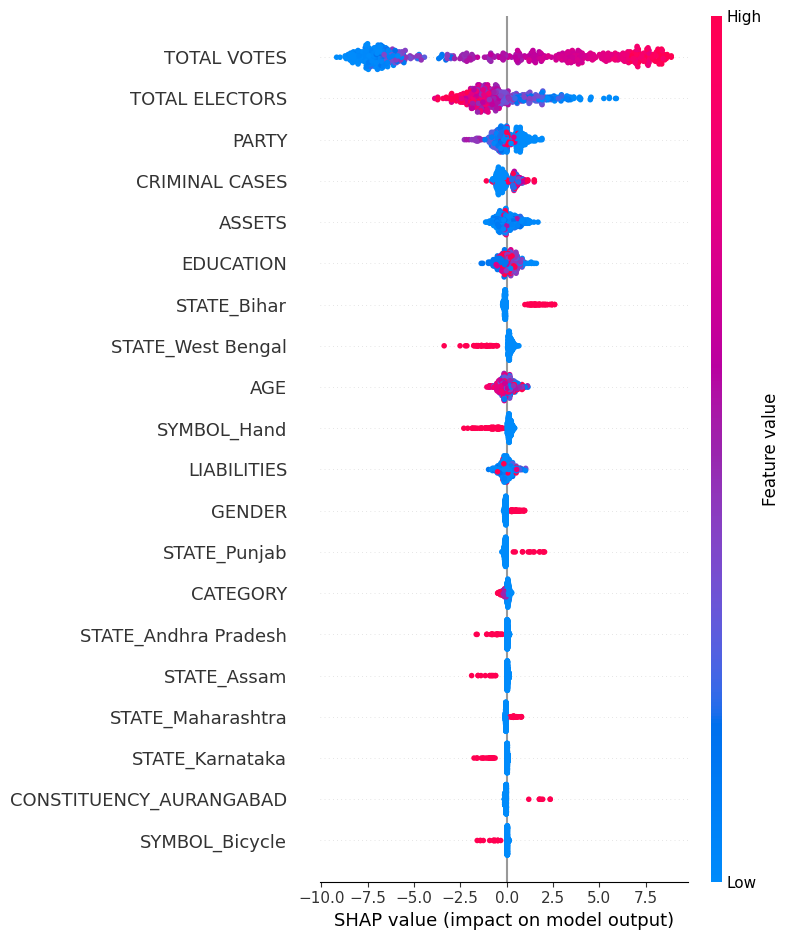

In [ ]:
explainer=shap.Explainer(xgb)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0])
#shap.force_plot(expected_value, sample_shap_values, X_test.iloc[sample_index], link="logit")

TESTING

In [ ]:
new_data=vote.sample()
new_data

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL CASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL VOTES,POSTAL VOTES,TOTAL VOTES,OVER TOTAL ELECTORS IN CONSTITUENCY,OVER TOTAL VOTES POLLED IN CONSTITUENCY,TOTAL ELECTORS
1908,Bihar,SHEOHAR,Shamim Alam,0,NCP,Clock,MALE,0,51.0,GENERAL,12th Pass,6324527,150000,13239,30,13269,0.78691,1.320394,1686215


In [ ]:
import warnings
warnings.filterwarnings("ignore")
'''new_data = pd.DataFrame({
    'STATE': ['Telangana'],
    'CONSTITUENCY': ['ADILABAD'],
    'PARTY': ['BJP'],
    'SYMBOL': ['Lotus'],
    'GENDER': ['MALE'],
    'CRIMINAL CASES': [3],
    'AGE': [52],
    'CATEGORY': ['ST'],
    'EDUCATION': ['12th Pass'],
    'TOTAL VOTES': [314057],
    'TOTAL ELECTORS': [1489790],
    'ASSETS': [36491000],
    'LIABILITIES': [15300000]
})'''
out=new_data['WINNER']
new_data=new_data.drop('WINNER', axis=1)
new_data['GENDER'].replace({'MALE': 1, 'FEMALE': 2}, inplace=True)
new_data['CATEGORY'].replace({'GENERAL': 1, 'SC': 2, 'ST': 3}, inplace=True)
new_data['PARTY'].replace(parties_dict, inplace=True)
new_data['EDUCATION'].replace(edu_dict, inplace=True)
missing_columns = set(X.columns) - set(new_data.columns)
for column in missing_columns:
    new_data[column] = 0
new_data = new_data[X.columns]
new_data[scaling_columns] = standardScaler.transform(new_data[scaling_columns])

predictions = decision_tree.predict(new_data)
print("DECISION TREE:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")
print()
predictions=svm.predict(new_data)
print("SVM:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")
print()
predictions=xgb.predict(new_data)
print("XG Boost:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")

DECISION TREE:
Predicted Value= [1]
Actual Value= 1593    0
Name: WINNER, dtype: int64
Accuracy: 0.00
SVM:
Predicted Value= [0]
Actual Value= 1593    0
Name: WINNER, dtype: int64
Accuracy: 1.00
XG Boost:
Predicted Value= [0]
Actual Value= 1593    0
Name: WINNER, dtype: int64
Accuracy: 1.00


In [ ]:
new_data=df_total_upsampled.sample()
out=new_data['WINNER']
new_data=new_data.drop("WINNER", axis=1)
predictions = decision_tree.predict(new_data)
print("DECISION TREE:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")
print()
predictions=svm.predict(new_data)
print("SVM:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")
print()
predictions=xgb.predict(new_data)
print("XG Boost:")
print("Predicted Value=",predictions)
print("Actual Value=",out)
accuracy = accuracy_score(out, predictions)
print(f"Accuracy: {accuracy:.2f}")

DECISION TREE:
Predicted Value= [1]
Actual Value= 749    1
Name: WINNER, dtype: int64
Accuracy: 1.00

SVM:
Predicted Value= [1]
Actual Value= 749    1
Name: WINNER, dtype: int64
Accuracy: 1.00

XG Boost:
Predicted Value= [1]
Actual Value= 749    1
Name: WINNER, dtype: int64
Accuracy: 1.00


Our project demonstrates commendable performance across multiple machine learning algorithms. The Decision Tree model yields accurate predictions, offering a clear and interpretable decision-making process. The Random Forest algorithm further improves accuracy, leveraging the strength of ensemble learning to handle diverse data patterns. Support Vector Machines (SVM) exhibit robust predictive capabilities, especially after optimization through grid search, showcasing their versatility in capturing intricate decision boundaries. XGBoost, a gradient boosting algorithm, attains high accuracy and provides insights into feature importance.
Comparative study metrics, such as accuracy, precision, recall, and F1 score, reinforce the efficacy of each model. Notably, SVM with grid search achieves a remarkable balance between precision and recall, making it a promising choice for election prediction tasks. The visualization of confusion matrices and classification reports enhances the interpretability of model performance.
All the 4 models, provided a remarkable accuracy, which enhanced on applying grid-search algorithm.
